In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import lightgbm as lgb
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [39]:
df= pd.read_csv('training.csv')

In [40]:
df.head()


,property_id,zone,sub_type,street_name,street_number,address_line_2,city_name,zip_code,days_on_market,build_date,...,basement,central_hvac,misc_features,exterior_color,exterior_material,initial_price,initial_value,purchase_decision,investment,final_price
0,1677886,residential,single family home,Thompson Prairie,45,NaN,Kellyfurt,91133,65,1971-11-22,...,1.0,0,NaN,grey,wood,128000.0,119400.0,1,41590,155000.0
1,5185610,residential,townhouse,Powell Gateway,13,NaN,New Gilbertside,66853,33,1977-12-01,...,0.0,1,NaN,grey,wood,184000.0,188500.0,1,34950,237000.0
2,8329034,residential,single family home,Elizabeth Mountain,68,NaN,South Robertville,99996,69,2012-09-19,...,1.0,1,NaN,white,brick,224000.0,218500.0,1,61050,278000.0
3,4831786,residential,townhouse,Bradley Well,51,NaN,Kellyland,25448,119,1904-09-23,...,0.0,0,patio,grey,brick,263000.0,277900.0,1,54320,361000.0
4,3621202,residential,single family home,Hendrix Run,275,NaN,South Suzannemouth,40464,110,1916-12-05,...,0.0,1,NaN,other,concrete_poured,265000.0,265700.0,1,44690,323000.0


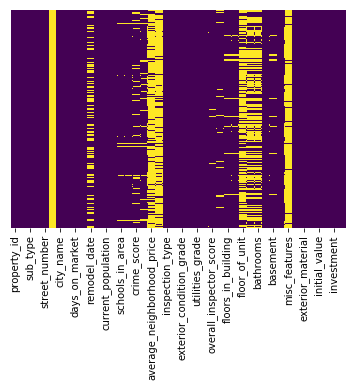

In [41]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [42]:
df1=df.drop([ 'address_line_2','street_name','street_number','address_line_2','city_name','zip_code','build_date','remodel_date','misc_features','average_neighborhood_price','damage_code','floor_of_unit','bedrooms','bathrooms'] , axis=1)

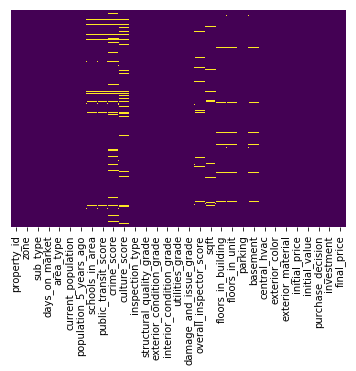

In [43]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [44]:
df1.isnull().values.any()

True

In [45]:
df1 = df1[np.isfinite(df1['floors_in_building'])]

In [46]:
#fill null values
mean= df1['schools_in_area'].median(skipna=True)
df1['schools_in_area']=df1['schools_in_area'].fillna(mean)
mean= df1['crime_score'].median(skipna=True)
df1['crime_score']=df1['crime_score'].fillna(mean)
mean= df1['culture_score'].median(skipna=True)
df1['culture_score']=df1['culture_score'].fillna(mean)
mean= df1['public_transit_score'].median(skipna=True)
df1['public_transit_score']=df1['public_transit_score'].fillna(mean)
mean= df1['schools_in_area'].median(skipna=True)
df1['overall_inspector_score']=df1['overall_inspector_score'].fillna(mean)
mean= df1['overall_inspector_score'].median(skipna=True)
df1['sqft']=df1['sqft'].fillna(mean)
mean= df1['sqft'].median(skipna=True)


In [47]:
df1['profit']=df1['final_price']-df1['investment']-df1['initial_price']
df1.loc[df1.profit < 500, 'purchase_decision'] = 0

In [48]:
df1['population_increase']=df1['current_population']-df1['population_5_years_ago']
df1.loc[df1.population_increase<0,'population_increase']=0
df1.loc[df1.population_increase>0,'population_increase']=1

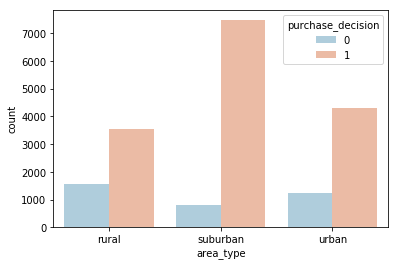

In [49]:
sns.countplot(x='area_type',hue='purchase_decision',data=df1,palette='RdBu_r') #rural area have less ratio of success

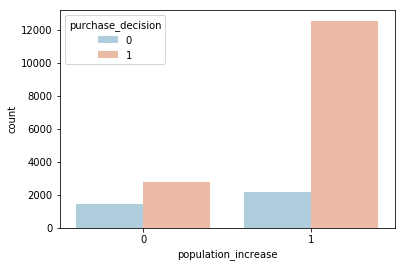

In [50]:
sns.countplot(x='population_increase',hue='purchase_decision',data=df1,palette='RdBu_r') 
#if there is increase in population, demand increase and so profit increase

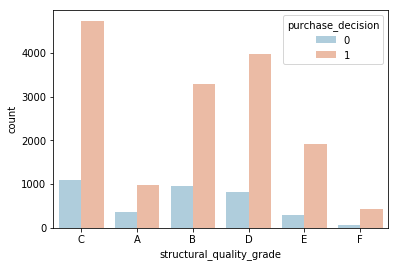

In [51]:
sns.countplot(x='structural_quality_grade',hue='purchase_decision',data=df1,palette='RdBu_r')

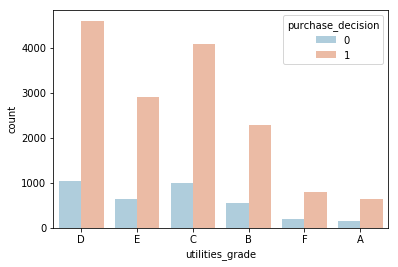

In [52]:
sns.countplot(x='utilities_grade',hue='purchase_decision',data=df1,palette='RdBu_r')

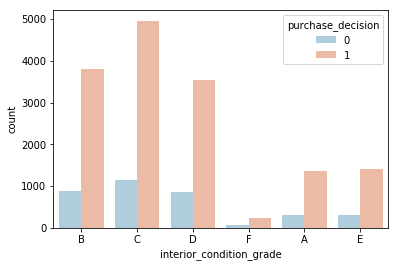

In [53]:
sns.countplot(x='interior_condition_grade',hue='purchase_decision',data=df1,palette='RdBu_r')

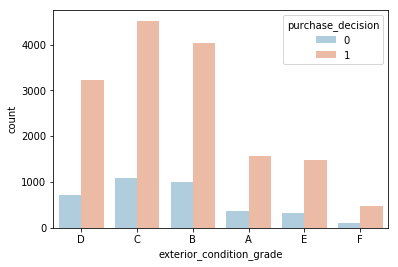

In [54]:
sns.countplot(x='exterior_condition_grade',hue='purchase_decision',data=df1,palette='RdBu_r')

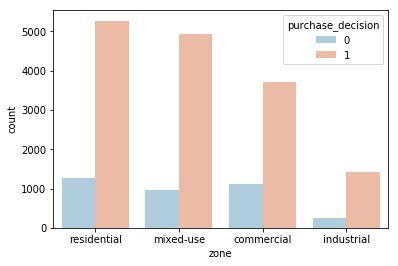

In [55]:
sns.countplot(x='zone',hue='purchase_decision',data=df1,palette='RdBu_r')

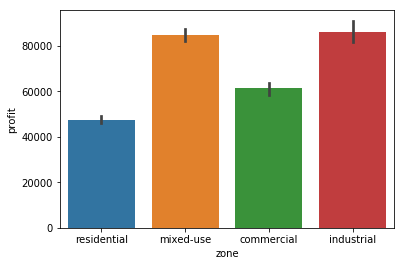

In [56]:
sns.barplot(x='zone',y='profit',data=df1)

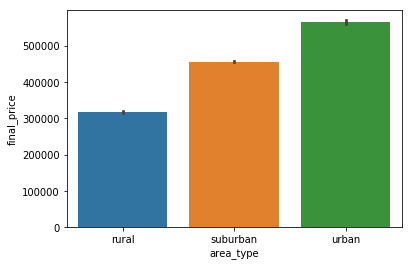

In [57]:
sns.barplot(x='area_type',y='final_price',data=df1)

In [58]:
cor=df1[['zone','days_on_market','schools_in_area','public_transit_score','current_population','population_5_years_ago','profit','crime_score','purchase_decision']]

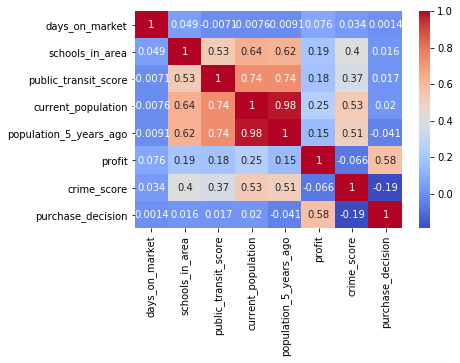

In [59]:
sns.heatmap(cor.corr(),cmap='coolwarm',annot=True)

In [60]:
#starting machine learning preparation


In [61]:
df2 = pd.get_dummies(df1, columns=['zone','sub_type','area_type','inspection_type','structural_quality_grade','exterior_condition_grade','interior_condition_grade','utilities_grade','exterior_color','exterior_material','damage_and_issue_grade'])

In [62]:
from sklearn.model_selection import train_test_split
X = df2.drop(['property_id','purchase_decision','population_5_years_ago', 'investment',
       'final_price', 'profit'],axis=1)
y = df2['purchase_decision']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2= GradientBoostingClassifier(random_state=0)
clf3 = GaussianNB()

In [65]:
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('gbc', clf2), ('gnb', clf3)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)
pre=eclf1.predict(X_test)

In [67]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(pre,y_test))
print(confusion_matrix(y_test,pre))

             precision    recall  f1-score   support

          0       0.07      0.94      0.13        79
          1       1.00      0.83      0.90      5598

avg / total       0.99      0.83      0.89      5677

[[  74  968]
 [   5 4630]]


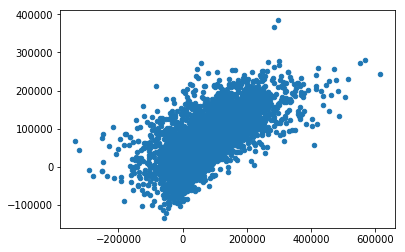

In [68]:
X = df2.drop(['property_id','current_population','purchase_decision','population_5_years_ago', 'investment',
       'final_price', 'profit'],axis=1)
y = df2['profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
from sklearn.linear_model import LinearRegression
lm = LinearRegression(n_jobs=11)
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions,s=20)